In [ ]:
##Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz

from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge

def balance(data): #sample it down to 1200 to balance out
    zero = data[data['Potability']==0] #has 1200
    one = data[data['Potability']==1] #has 811
    resampledData = resample(one, n_samples=1200)
    updatedData = shuffle(pd.concat([zero, resampledData]))
    return updatedData

def variableClean(data):
    indepVariable = data.drop('Potability', axis=1).copy()
    depVariable = data['Potability'].copy()
    scal = StandardScaler()
    features = indepVariable.columns
    indepVariable[features] = scal.fit_transform(indepVariable[features])
    return indepVariable, depVariable

def getMax(arr):
    maxVal = -1
    index = -1
    for i in range(len(arr)):
        if(maxVal < arr[i]):
            maxVal = arr[i]
            index = i
    return {'index': index,
           'maximum_value': maxVal}

def getScore(trainSize, testMean):
    max_test = getMax(testMean)
    index = max_test['index']
    maxValue = max_test['maximum_value']
    optimalTrainSize = trainSize[index]
    conclusion = f'With the train size of {optimalTrainSize} yields the score of {maxValue}.'
    return conclusion

def prediction(df, xTrain, yTrain, xTest, yTest):
    output = {}
    start = time.time()
    df.fit(xTrain, yTrain)
    test_pred = df.predict(xTest)
    cRep = classification_report(yTest, test_pred, digits=4)
    f1Score = f1_score(yTest, test_pred)
    end = time.time()
    wallClockPred = end - start
    outputUpdate = (('classification_report', cRep), ('f1_score', f1Score), ('wall_clock', wallClockPred))
    output.update(outputUpdate)
    return output

def printPredictions(pred):
    print('Time spent for prediction: ', pred['wall_clock'])
    print(pred['classification_report'])
    print('f1-Score: ', pred['f1_score'])


In [ ]:
original_data = pd.read_csv('/Users/jacobseo/cs7641/assignment1/data/water_potability.csv')
df = original_data.copy()
##Data source: https://www.kaggle.com/adityakadiwal/water-potability
#PH, Sulfate, and Trihalomethanes have NaN values are missing

df.isnull().sum()

In [53]:
##Sensitive data impute may be misleading
df = df.dropna()
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [54]:
#instanceNo = len(df.index)
#print('# of instances: ', instanceNo)

##To see if it is biased or not (it is biased since its not balanced)
#df.Potability.value_counts()

#df[df['Potability']==0][['ph','Sulfate','Trihalomethanes']].median()
#df[df['Potability']==1][['ph','Sulfate','Trihalomethanes']].median()
#df['ph'].fillna(value=df['ph'].median(),inplace=True)
#df['Sulfate'].fillna(value=df['Sulfate'].median(),inplace=True)
#df['Trihalomethanes'].fillna(value=df['Trihalomethanes'].median(),inplace=True)

In [55]:
df = balance(df)
df.Potability.value_counts()

X, y = variableClean(df)

[learning_curve] Training set sizes: [  21   43   64   86  108  129  151  172  194  215  237  259  280  302
  324  345  367  388  410  432  453  475  496  518  540  561  583  604
  626  648  669  691  712  734  756  777  799  820  842  864  885  907
  928  950  972  993 1015 1036 1058 1080 1101 1123 1144 1166 1188 1209
 1231 1252 1274 1296 1317 1339 1360 1382 1404 1425 1447 1468 1490 1512
 1533 1555 1576 1598 1620 1641 1663 1684 1706 1728 1749 1771 1792 1814
 1836 1857 1879 1900 1922 1944 1965 1987 2008 2030 2052 2073 2095 2116
 2138 2160]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 out of 1000 | elapsed:    0.7s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done 193 out of 1000 | elapsed:    1.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done 294 out of 1000 | elapsed:    1.7s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done 395 out of 1000 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done 496 out of 1000 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 597 out of 1000 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done 698 out of 1000 | elapsed:    3.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 799 out of 1000 | elapsed:    3.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 900 out of 1000 | elapsed:    3.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


'With the train size of 2160 yields the score of 0.7829166666666667.'

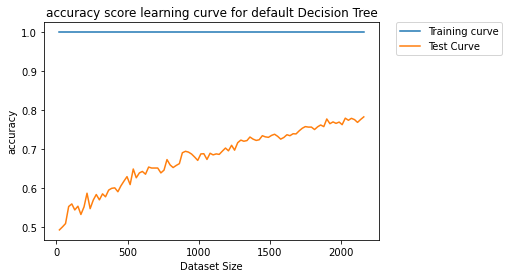

In [56]:
##Default learning Curve
train_sizes, train_scores, test_scores = learning_curve(DecisionTreeClassifier(random_state=42), X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01,1.0,100), verbose=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training curve')
plt.plot(train_sizes, test_mean, label='Test Curve')
plt.xlabel("Dataset Size")
plt.ylabel("accuracy")
plt.title("accuracy score learning curve for default Decision Tree")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

getScore(train_sizes, test_mean)

In [38]:
##Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

##GridSearch
params = {
    'criterion': ['gini'],
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50, 60, 70],
}

gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, cv=10, n_jobs=-1, verbose=10, return_train_score=True, scoring='accuracy')
gs.fit(X_train, y_train)

##Best Results
best_parameter = gs.best_params_
best_score = gs.best_score_

print("best parameter: ", best_parameter)
print("best score: ", best_score)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
best parameter:  {'criterion': 'gini', 'max_depth': 35, 'min_samples_leaf': 1}
best score:  0.7293420925280681


In [39]:
results_data = pd.DataFrame(gs.cv_results_)
min_samples_leaf = 'min_samples_leaf'
max_depth = 'max_depth'
suf_param = 'param_'
optimal_results_data = results_data.loc[results_data[suf_param+min_samples_leaf] == best_parameter[min_samples_leaf]]
optimal_results_data

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.020626,0.001643,0.003666,0.001296,gini,5,1,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.656250,0.652778,...,0.670656,0.673359,0.668340,0.674131,0.677992,0.675676,0.664222,0.682748,0.674543,0.005380
9,0.031623,0.001156,0.002640,0.000355,gini,10,1,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.687500,0.666667,...,0.762162,0.733591,0.767954,0.752896,0.740154,0.766409,0.743728,0.781552,0.758397,0.014875
18,0.039779,0.003341,0.002384,0.000118,gini,15,1,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.677083,0.687500,...,0.902703,0.828958,0.911583,0.865251,0.815830,0.874903,0.883057,0.882285,0.869121,0.028492
27,0.046902,0.006468,0.002516,0.000146,gini,20,1,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.680556,0.666667,...,0.978764,0.933205,0.986873,0.948649,0.916602,0.933205,0.973755,0.967194,0.951971,0.022048
36,0.044355,0.002909,0.002796,0.000889,gini,25,1,"{'criterion': 'gini', 'max_depth': 25, 'min_sa...",0.697917,0.697917,...,1.000000,0.979537,1.000000,0.996525,0.974131,0.986100,0.997684,0.995755,0.988417,0.010311
45,0.045435,0.003149,0.002654,0.000182,gini,30,1,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.725694,0.701389,...,1.000000,0.999614,1.000000,1.000000,0.997297,0.998456,1.000000,1.000000,0.998649,0.001862
54,0.045516,0.003787,0.002542,0.000186,gini,35,1,"{'criterion': 'gini', 'max_depth': 35, 'min_sa...",0.718750,0.697917,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
63,0.044657,0.002456,0.002468,0.000152,gini,40,1,"{'criterion': 'gini', 'max_depth': 40, 'min_sa...",0.718750,0.697917,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
72,0.045137,0.003168,0.002598,0.000277,gini,45,1,"{'criterion': 'gini', 'max_depth': 45, 'min_sa...",0.718750,0.697917,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
81,0.044635,0.002310,0.002622,0.000171,gini,50,1,"{'criterion': 'gini', 'max_depth': 50, 'min_sa...",0.718750,0.697917,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


Text(0.5, 1.0, 'Validation for the Decision Tree')

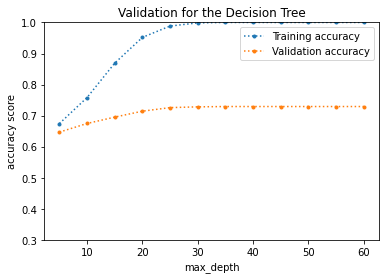

In [40]:
##GridSearch Plotting
fig, ax = plt.subplots()
optimal_results_data.plot(x=suf_param+max_depth, y='mean_train_score', label='Training accuracy', ax=ax, marker='.', ls=':')
optimal_results_data.plot(x=suf_param+max_depth, y='mean_test_score', label='Validation accuracy', ax=ax, marker='.', ls=':')

ax.set_xlabel('max_depth')
ax.set_ylabel('accuracy score')
ax.set_ylim(bottom=0.3, top=1.0)
ax.set_title("Validation for the Decision Tree")

[learning_curve] Training set sizes: [  25   77  128  180  232  283  335  387  439  490  542  594  645  697
  749  800  852  904  955 1007 1059 1110 1162 1214 1265 1317 1369 1420
 1472 1524 1576 1627 1679 1731 1782 1834 1886 1937 1989 2041 2092 2144
 2196 2247 2299 2351 2402 2454 2506 2558]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of 250 | elapsed:    0.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  43 out of 250 | elapsed:    0.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  69 out of 250 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  95 out of 250 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 121 out of 250 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 147 out of 250 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 173 out of 250 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 199 out of 250 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 225 out of 250 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.5s finished


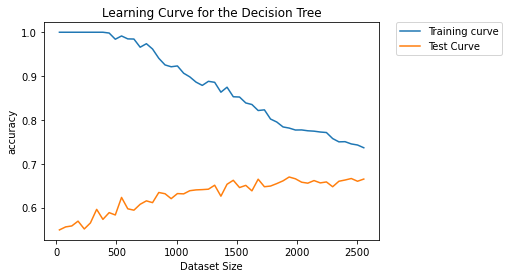

In [41]:
##learning Curve
optimal_df = DecisionTreeClassifier(random_state=42, ccp_alpha=0.002, criterion='gini', max_depth= best_parameter[max_depth], min_samples_leaf=best_parameter[min_samples_leaf])
train_sizes, train_scores, test_scores = learning_curve(optimal_df, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01,1.0,50), verbose=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training curve')
plt.plot(train_sizes, test_mean, label='Test Curve')
plt.xlabel("Dataset Size")
plt.ylabel("accuracy")
plt.title("Learning Curve for the Decision Tree")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [42]:
##Predictions
pred = prediction(optimal_df, X_train, y_train, X_test, y_test)
printPredictions(pred)

Time spent for prediction:  0.05195808410644531
              precision    recall  f1-score   support

           0     0.7039    0.7773    0.7387       211
           1     0.4598    0.3670    0.4082       109

    accuracy                         0.6375       320
   macro avg     0.5818    0.5721    0.5735       320
weighted avg     0.6207    0.6375    0.6261       320

f1-Score:  0.40816326530612246
